# **Downloading the required modules**

In [ ]:
#pip install

# **Importing the required packages and libraries**

In [ ]:
import re
import pandas as pd
import numpy as np
import random
import nltk
import sklearn
import scipy.stats
#uncomment if gutenberg is not already downlaoded
nltk.download('gutenberg')
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import gutenberg
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models
from gensim.models import CoherenceModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition  import PCA
from sklearn.metrics import cohen_kappa_score
import scipy.cluster.hierarchy as shc
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
import gensim.downloader as api

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data preparation and pre-processing

In [ ]:
def get_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0]
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Create a dictionary to store assigned author numbers
author_arr = []

def get_book_partitions(book_name, author_name, partition_size=150, num_partitions=200):
    # Download the book
    words = gutenberg.words(book_name)

    # Get the total number of words in the book
    total_words = len(words)

    # Randomly select starting indices for the partitions
    partition_indices = random.sample(
        range(0, total_words - partition_size), num_partitions)

    # Create a dictionary to store the partitions and their labels
    partitions = {}

    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()

    # Get the stop words list
    stop_words = set(stopwords.words('english'))

    for i, index in enumerate(partition_indices):
        # Get the partition text
        partition = " ".join(words[index:index+partition_size])

        # Clean the text
        partition = re.sub(r"[^a-zA-Z]{3,}", ' ', partition)
        partition = partition.lower()

        # Tokenize the partition
        partition = nltk.word_tokenize(partition)

        # Remove stop words and lemmatize the tokens
        partition = [lemmatizer.lemmatize(token, get_pos(token))
            for token in partition
            if token not in stop_words
        ]

        label = "{}_{}".format(i, book_name)  # include book name in the label

        # Get the true label for evaluating clusters
        if author_name not in author_arr:
            author_arr.append(author_name)
        true_label = author_arr.index(author_name)

        # Add the partition and its labels to the dictionary
        partitions[label] = {'text': ' '.join(partition), 'true_label': true_label}

    # Convert the partitions dictionary to a DataFrame
    partitions_df = pd.DataFrame.from_dict(
        partitions, orient='index')
    partitions_df.reset_index(inplace=True)
    partitions_df.rename(columns={'index': 'label'}, inplace=True)

    return partitions_df

def create_dataframe(text, author_name, genre):
  partitions = get_book_partitions(text, author_name)
  partitions["author_name"] = author_name
  partitions["genre"] = genre
  return partitions

# Print the list of available books
#print("List of available books: ", gutenberg.fileids())

books = [ 
		{ 
			"file": 'chesterton-brown.txt',
			"author": "G.K. Chesterton",
			"genre": "Mystery"
		},
		{
			"file": 'austen-persuasion.txt',
			"author": "Jane Austen",
			"genre": "Romance"
		},
		{
			"file": 'blake-poems.txt',
			"author": "William Blake",
			"genre": "Poetry"
		},
		{
			"file": 'bible-kjv.txt',
			"author": "King James",
			"genre": "Religion"
		},
		{
			"file": 'milton-paradise.txt',
			"author": "Milton",
			"genre": "Fiction"
		}
	]

for book in books: 
	df = create_dataframe(book["file"], book["author"], book["genre"])
	book["df"] = df

result = pd.concat([x["df"] for x in books])

# Make a csv file of the partitions to make the data easier to consume
result.to_csv("book_partitions.csv", index=True)
result

,label,text,true_label,author_name,genre
0,0_chesterton-brown.txt,summer palace even spoke five silent men weapo...,0,G.K. Chesterton,Mystery
1,1_chesterton-brown.txt,", like know sir simon one exmoor great pal wou...",0,G.K. Chesterton,Mystery
2,2_chesterton-brown.txt,twilight tell affair instinctively twist untwi...,0,G.K. Chesterton,Mystery
3,3_chesterton-brown.txt,admiral tell family history ask father brown g...,0,G.K. Chesterton,Mystery
4,4_chesterton-brown.txt,islet rate go islet seem swim towards like shi...,0,G.K. Chesterton,Mystery
...,...,...,...,...,...
195,195_milton-paradise.txt,know arm overpower companion dear found worthy...,4,Milton,Fiction
196,196_milton-paradise.txt,great deliverance seed come woman seed mankind...,4,Milton,Fiction
197,197_milton-paradise.txt,hour within hallow limit thou appear back infe...,4,Milton,Fiction
198,198_milton-paradise.txt,yoke ye submit neck choose bend supple knee ye...,4,Milton,Fiction


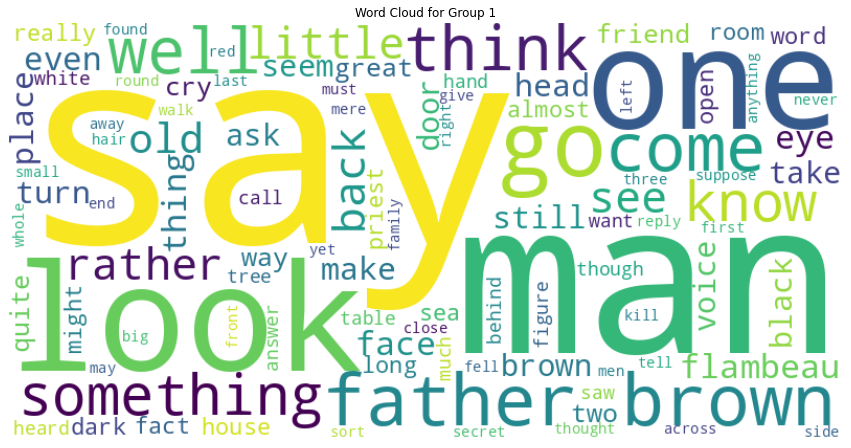

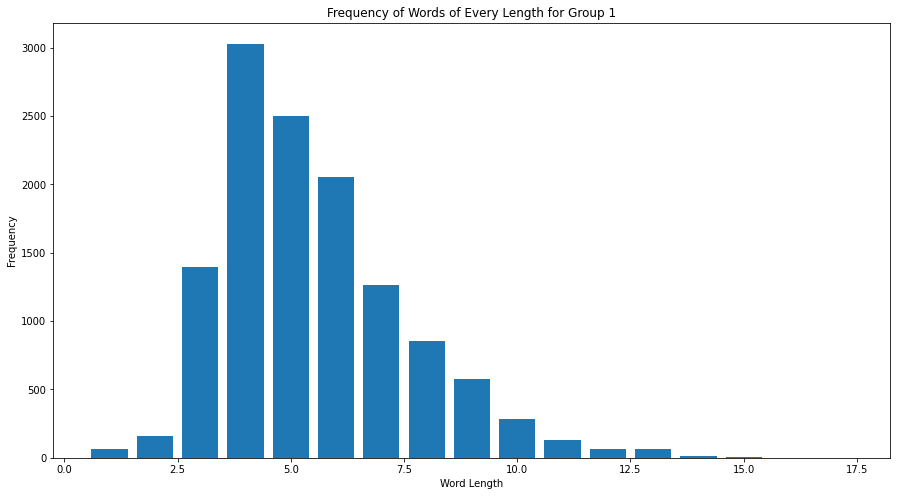

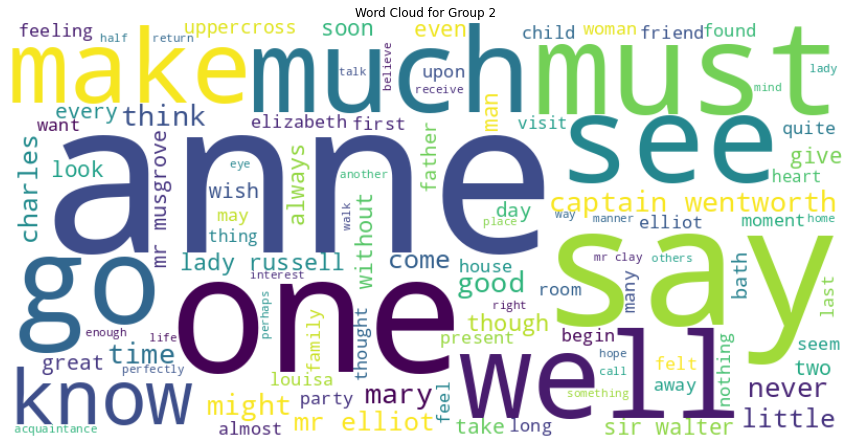

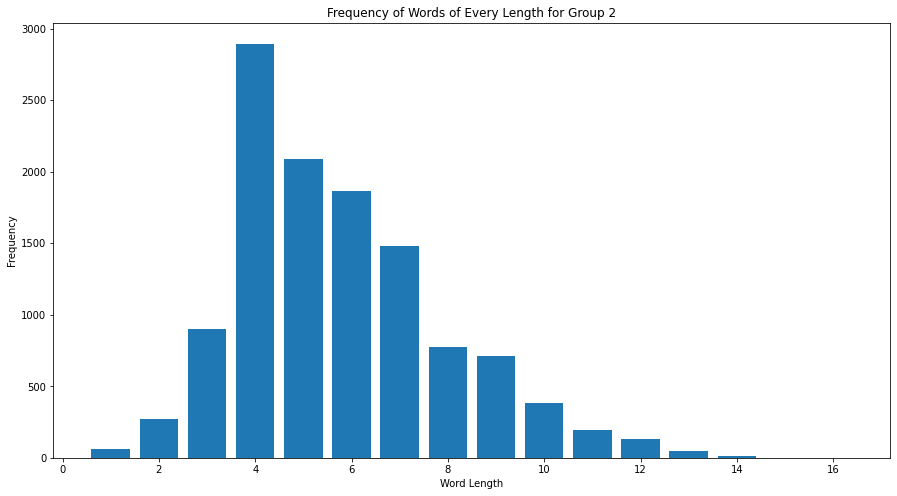

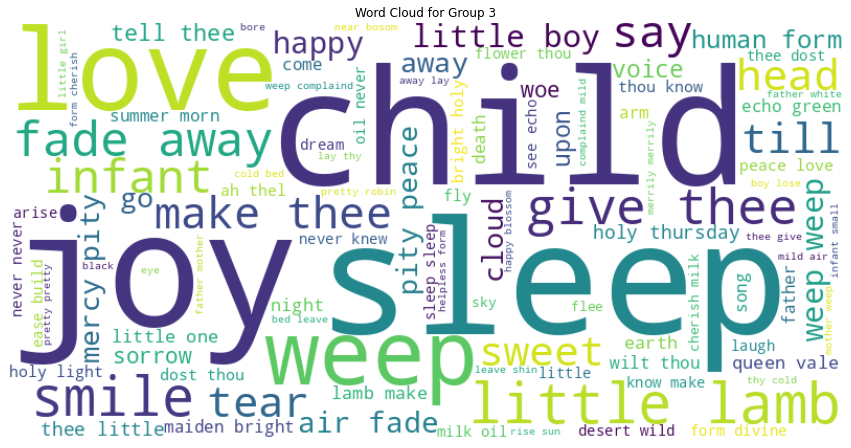

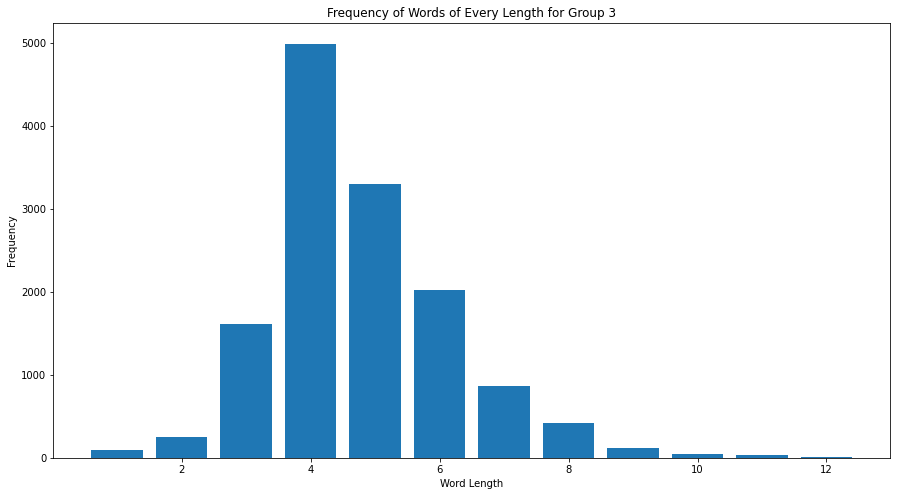

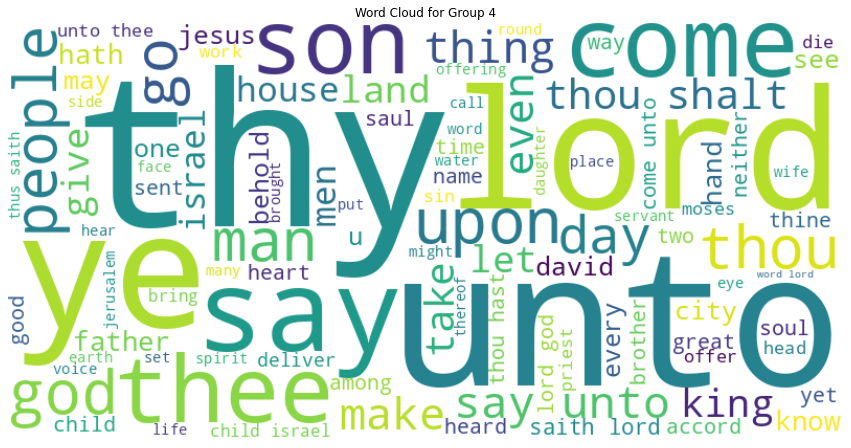

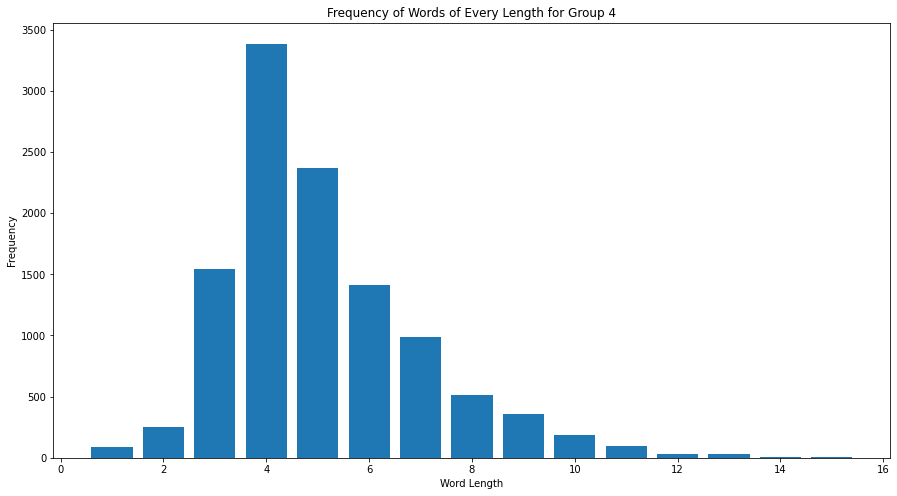

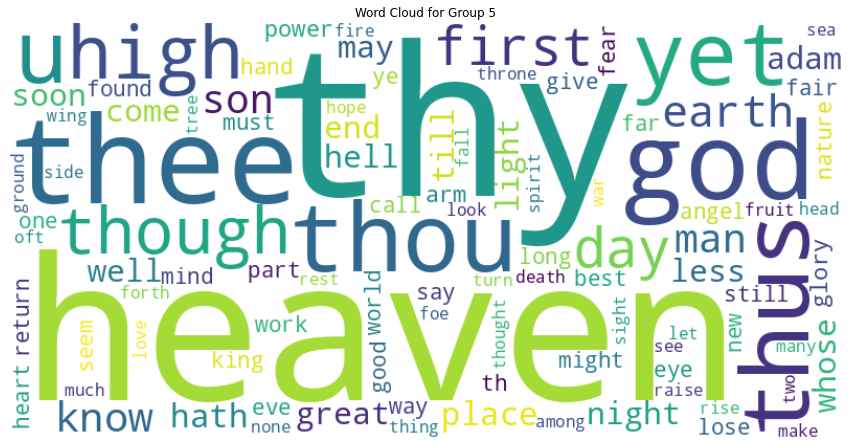

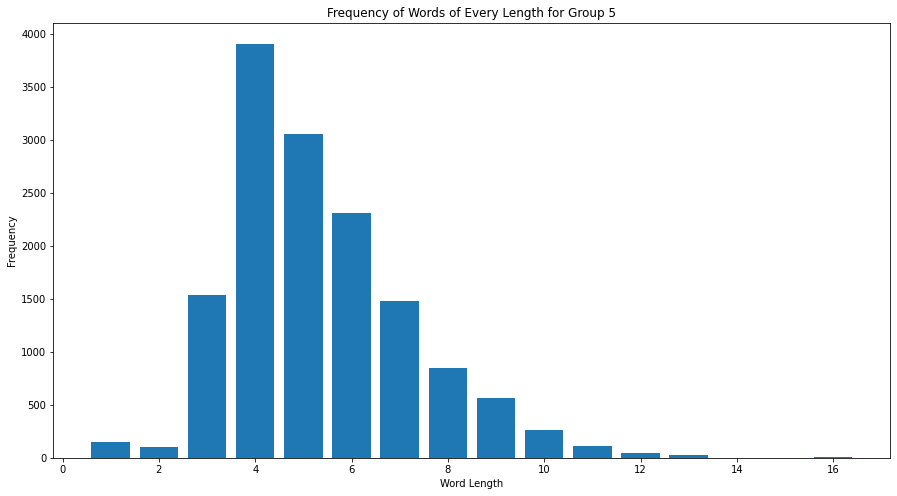

In [ ]:
# Load the dataset
df = pd.read_csv("book_partitions.csv")

# Split the text column into groups of 200 cells
text_columns = [df["text"][i:i+200] for i in range(0, len(df), 200)]
# Generate a word cloud for each group of 200 cells
for i, text_column in enumerate(text_columns):
    text = " ".join(text_column.tolist())
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Group {i+1}')
    plt.show()


# Plot the frequency of words of every length
    words_lengths = [len(word) for word in text.split()]
    length_counts = pd.Series(words_lengths).value_counts().sort_index()
    plt.figure(figsize=(15, 8))
    plt.bar(length_counts.index, length_counts.values)
    plt.xlabel('Word Length')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Words of Every Length for Group {i+1}')
    plt.show()

In [ ]:
X = result['text'].values
y = result['author_name'].values

# Feature Engineering

##1. Bag of Words

In [ ]:
count = CountVectorizer(min_df=3, analyzer='word', ngram_range=(1,2)) #Ignoring frequency <3 and considering both uni and bi-grams
bow = count.fit_transform(X)
array_bow = bow.toarray()
BOW_feature_names = count.get_feature_names_out()
X_BOW = pd.DataFrame(bow.toarray(), columns=BOW_feature_names) 
X_BOW

,aaron,abdiel,able,abner,abode,abomination,abraham,abroad,abroad see,abrupt,...,youth fearest,youth flee,youth maiden,youth morning,youth time,youthful,youthful pair,youthful spring,zeal,zion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##**2. TF-IDF**

In [ ]:
#TD_IDF
tf = TfidfVectorizer(analyzer='word',min_df= 3, ngram_range=(1, 2))
Tfid = tf.fit_transform(X)
array_tfid = Tfid.toarray()
tfid_feature_names = tf.get_feature_names_out()
X_Tfid = pd.DataFrame(Tfid.toarray(), columns=tfid_feature_names)
X_Tfid

,aaron,abdiel,able,abner,abode,abomination,abraham,abroad,abroad see,abrupt,...,youth fearest,youth flee,youth maiden,youth morning,youth time,youthful,youthful pair,youthful spring,zeal,zion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##3. **LDA**

In [ ]:
dictionary = corpora.Dictionary(result['text'].str.split())
corpus = [dictionary.doc2bow(text) for text in result['text'].str.split()]
ldamodel_new = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 150,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_new = ldamodel_new.inference(corpus)
pred_new

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


(array([[0.15774532, 0.00451925, 0.00451925, ..., 0.00969258, 0.11690549,
         0.03226351],
        [0.15726449, 0.00451925, 0.00451925, ..., 0.00969258, 0.11685505,
         1.0322636 ],
        [0.15720199, 0.00451925, 0.00451925, ..., 0.00969258, 0.11678547,
         1.0322635 ],
        ...,
        [3.1571543 , 0.00451925, 0.00451925, ..., 0.00969258, 0.98545855,
         0.03226351],
        [0.15715382, 0.00451925, 0.00451925, ..., 0.00969258, 0.11677309,
         0.03226351],
        [0.15715382, 0.00451925, 0.00451925, ..., 0.00969258, 0.11684734,
         0.03226351]], dtype=float32), None)

# Clustering Models

K-Means

In [ ]:
#K-means
def kMeans(clusters, X_data):
    kmeans_model= KMeans(n_clusters= clusters, init='k-means++', random_state=0)
    y_pred = kmeans_model.fit_predict(X_data)
    
    #Getting the Centroids
    centroids = kmeans_model.cluster_centers_
    u_labels = np.unique(y_pred)
    
    #Plotting the results
    
    for i in u_labels:
        plt.scatter(X_data[y_pred == i , 0] , X_data[y_pred == i , 1] , label = i)
    
    title = "K-Means Clustering with number of clusters = " + str(clusters)
    plt.title(title)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.show()
    return kmeans_model, y_pred
    

#reduce data dimension for visualization
def data_with_tsna(desired_data):
    tsna = TSNE(n_components= 2, random_state= 42)
    data_tsna = tsna.fit_transform(desired_data) 
    return data_tsna

## Bag-of-Words & K-Means



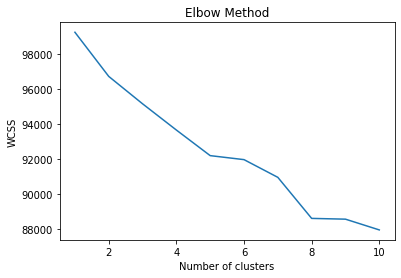

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_BOW)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow is at 5, which makes that the optimum number of clusters.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


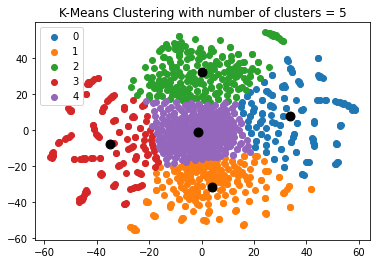

In [ ]:
bow_data = data_with_tsna(X_BOW)
bow_kmeans, bow_kmeans_pred = kMeans(5,bow_data)

Bag-of-words & EM

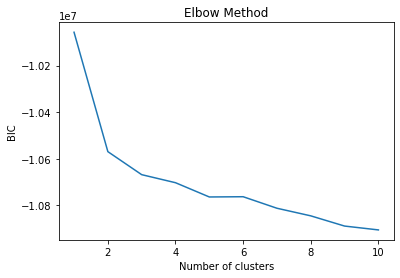

In [ ]:
bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical', n_init=10)
    gmm.fit(X_BOW)
    bic.append(gmm.bic(X_BOW))
plt.plot(range(1, 11), bic)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.show()

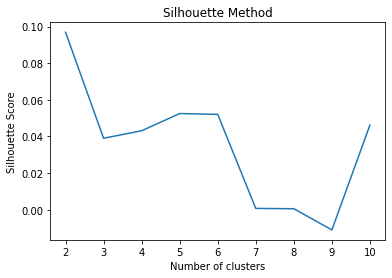

In [ ]:
silhouette_scores = []
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical', n_init=10)
    gmm.fit(X_BOW)
    y_pred = gmm.predict(X_BOW)
    score = silhouette_score(X_BOW, y_pred)
    silhouette_scores.append(score)
    
optimal_clusters = np.argmax(silhouette_scores) + 2

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Silhouette also has multiple peaks/elbows. Hence, we'll be combining both Elbow and Silhouette methods as follows.

In [ ]:
def combine(X_data):
    n_clusters = range(4,11)
    bic_scores = []
    silhouette_scores = []

    for n in n_clusters:
        gmm = GaussianMixture(n_components=n, covariance_type='spherical')
        gmm.fit(X_data)
        bic_scores.append(gmm.bic(X_data))
        silhouette_scores.append(silhouette_score(X_data, gmm.predict(X_data)))

    fig, ax1 = plt.subplots()

    ax1.plot(n_clusters, bic_scores, 'b*-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('BIC Score', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(n_clusters, silhouette_scores, 'ro-')
    ax2.set_ylabel('Silhouette Score', color='r')
    ax2.tick_params('y', colors='r')

    plt.title('BIC and Silhouette Scores for EM Clustering')
    plt.show()

    # Get best number of clusters using the combined method
    avg_scores = np.add(bic_scores, silhouette_scores) / 2
    best_n = np.argmax(avg_scores)
    print("Best number of clusters (combined method):", n_clusters[best_n])
    print("BIC score for best number of clusters:", bic_scores[best_n])
    print("Silhouette score for best number of clusters:", silhouette_scores[best_n])

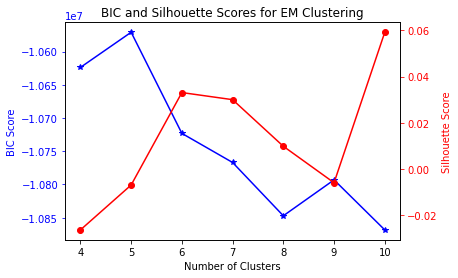

Best number of clusters (combined method): 5
BIC score for best number of clusters: -10570993.453155346
Silhouette score for best number of clusters: -0.0070033255575956


In [ ]:
combine(X_BOW)

In [ ]:
#EM
def em(clusters, X_data):
    gmm_model= GaussianMixture(n_components=clusters ,
                             covariance_type= "spherical" ,
                             n_init= 10 )
  
    y_pred= gmm_model.fit_predict(X_data)
    gmm_probability = gmm_model.predict_proba(X_data)

    #visualizing clusters
    title = "EM on BoW with number of clusters = " + str(clusters)
    plt.title(title)
    plt.scatter(X_data[:, 0], X_data[:, 1], c=y_pred, s=40, cmap='viridis')
    plt.scatter(gmm_model.means_[:, 0], gmm_model.means_[:, 1], c='black', s=100, alpha=1)
    # Plotting the cluster centers with black color and size 200 and 50% transparency

    return gmm_model, y_pred, gmm_probability

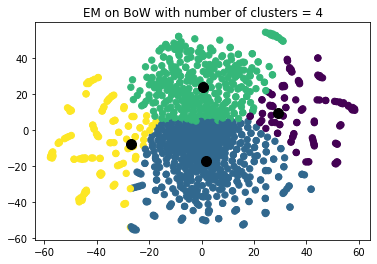

In [ ]:
bow_em, bow_em_pred, bow_em_prob = em(4,bow_data)

Bag-of-Words & Agglomerative Hierarchical Clustering

In [ ]:
def agglomerative_elbow(X_data):
    n_clusters = range(2, 11)
    linkage_types = ['ward', 'complete', 'average', 'single']
    silhouette_scores = np.zeros((len(n_clusters), len(linkage_types)))

    for i, k in enumerate(n_clusters):
        for j, linkage_type in enumerate(linkage_types):
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage_type)
            labels = model.fit_predict(X_data)
            silhouette_scores[i,j] = silhouette_score(X_data, labels)

    fig, ax = plt.subplots(figsize=(8,6))
    for j, linkage_type in enumerate(linkage_types):
        ax.plot(n_clusters, silhouette_scores[:,j], 'o--', label=linkage_type)

    ax.set_xticks(n_clusters)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette score')
    ax.legend()
    plt.show()

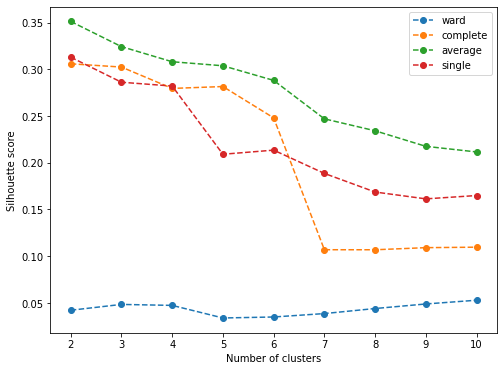

In [ ]:
agglomerative_elbow(X_BOW)

In [ ]:
#Agglomerative Hierarchical Clustering

def agg_hierarchical_cluster(clusters, X_data, title, method):
    # plot dendogram
    plt.figure(figsize=(10, 7)) 
    plt.title(title)

    dend= shc.dendrogram(shc.linkage(X_data, method=method))
    agg_model= AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')  
    y_pred= agg_model.fit_predict(X_data)
    return agg_model, y_pred

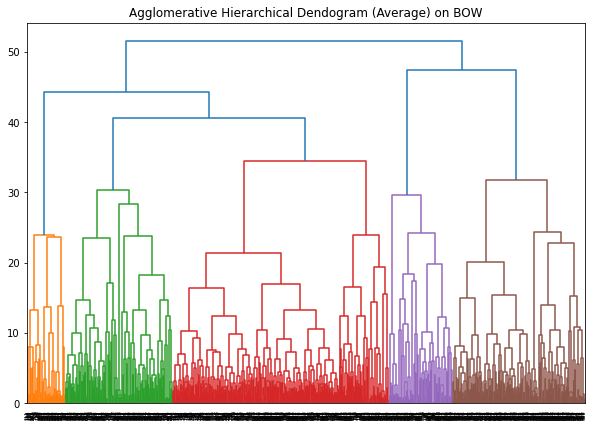

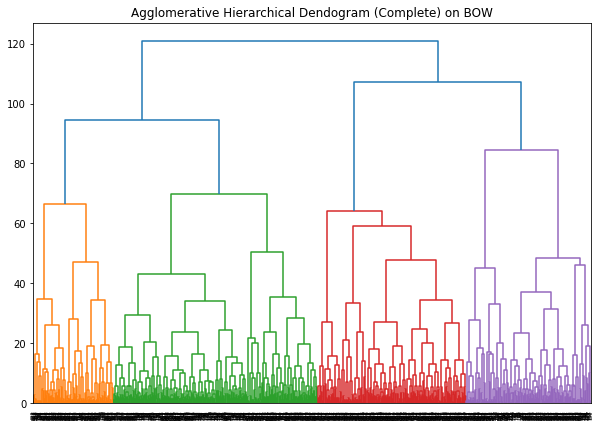

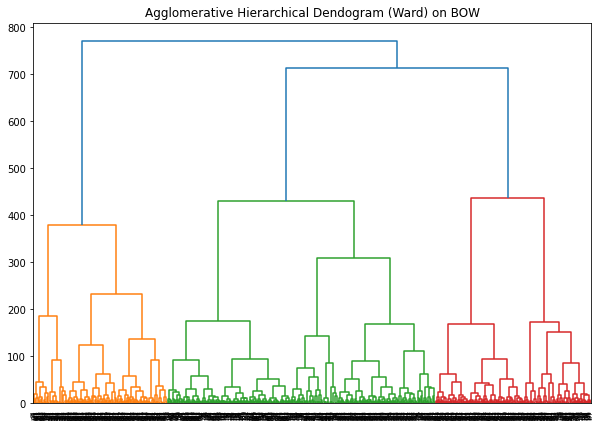

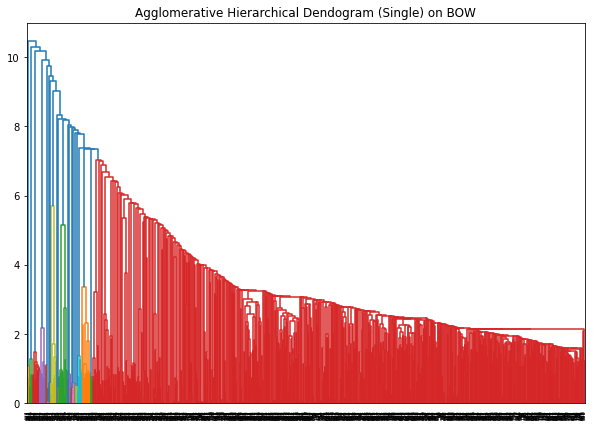

In [ ]:

#AHC Average on BOW
bow_agg_avg, bow_agg_avg_pred= agg_hierarchical_cluster(7, bow_data,"Agglomerative Hierarchical Dendogram (Average) on BOW", "average")

#AHC Complete on BOW
bow_agg_complete, bow_agg_complete_pred= agg_hierarchical_cluster(4, bow_data,"Agglomerative Hierarchical Dendogram (Complete) on BOW", "complete")

#AHC Ward on BOW
bow_agg_ward, bow_agg_ward_pred= agg_hierarchical_cluster(4, bow_data,"Agglomerative Hierarchical Dendogram (Ward) on BOW", "ward")

#AHC Single on BOW
bow_agg_single, bow_agg_single_pred= agg_hierarchical_cluster(5, bow_data,"Agglomerative Hierarchical Dendogram (Single) on BOW", "single")

TF-IDF & K-Means Clustering

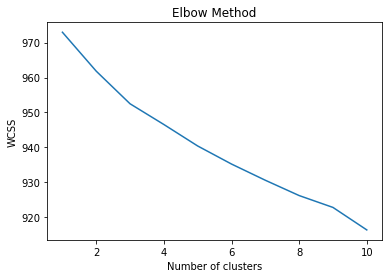

In [ ]:
#Finding out number of clusters (K-Means & TF-IDF) using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_Tfid)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow is at 6, which makes that the optimum number of clusters

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


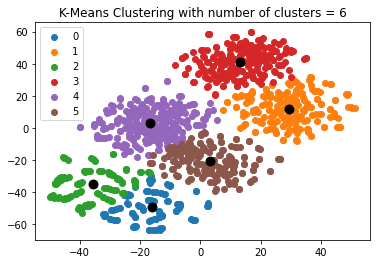

In [ ]:
#K-means on TF-IDF
tfidf_data = data_with_tsna(X_Tfid)
tfidf_kmeans, tfidf_kmeans_pred = kMeans(6,tfidf_data)


TF-IDF & EM

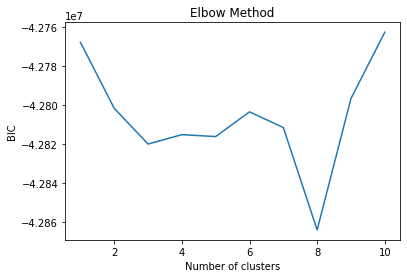

In [ ]:
#Finding out number of clusters (EM & TF-IDF) using elbow method
bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical', n_init=10)
    gmm.fit(X_Tfid)
    bic.append(gmm.bic(X_Tfid))
plt.plot(range(1, 11), bic)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.show()

Since the elbow method produced multiple elbows, we'll be analyzing the number of clusters using another method, Silhouette.

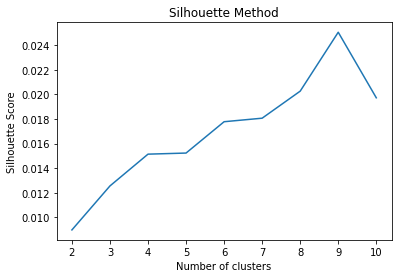

In [ ]:
#Finding out number of clusters (EM & TF-IDF) using Silhouette method
silhouette_scores = []
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical', n_init=10)
    gmm.fit(X_Tfid)
    y_pred = gmm.predict(X_Tfid)
    score = silhouette_score(X_Tfid, y_pred)
    silhouette_scores.append(score)
    
optimal_clusters = np.argmax(silhouette_scores) + 2

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Finding the optimum number of clusters using the combined method.

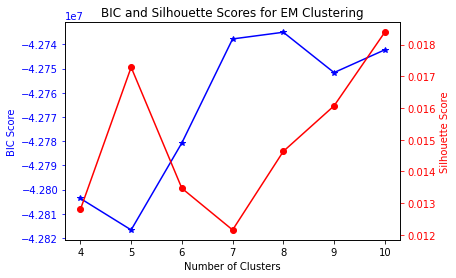

Best number of clusters (combined method): 8
BIC score for best number of clusters: -42735002.40483139
Silhouette score for best number of clusters: 0.014634424071976309


In [ ]:
combine(X_Tfid)

The optimum number of clusters for EM & TF-IDF is 10. Hence the EM model is developed with 10 clusters.

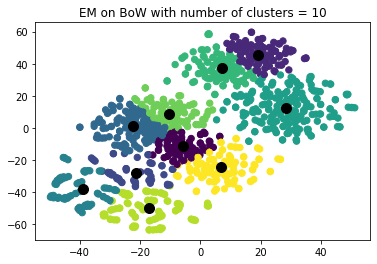

In [ ]:
#EM on TF-IDF
tfidf_em, tfidf_em_pred, tfidf_em_prob = em(10,tfidf_data)

TF-IDF & Agglomerative Hierarchical Clustering

Finding the optimum number of clusters for AHC using the elbow method

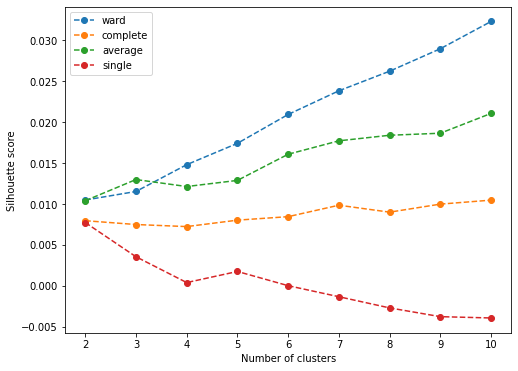

In [ ]:
agglomerative_elbow(X_Tfid)

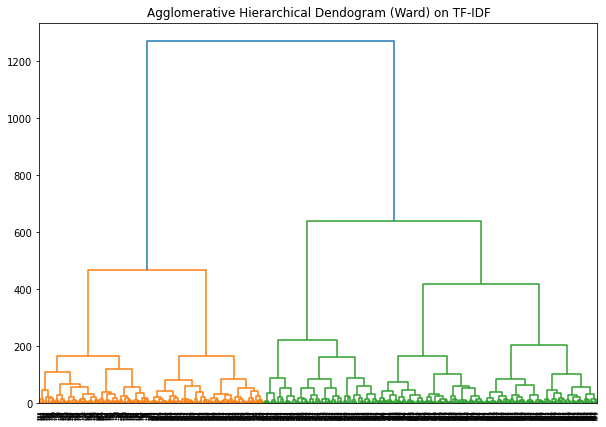

In [ ]:
#AHC Ward on TF-IDF
tfidf_agg_ward, tfidf_agg_ward_pred= agg_hierarchical_cluster(6, tfidf_data,"Agglomerative Hierarchical Dendogram (Ward) on TF-IDF", "ward")

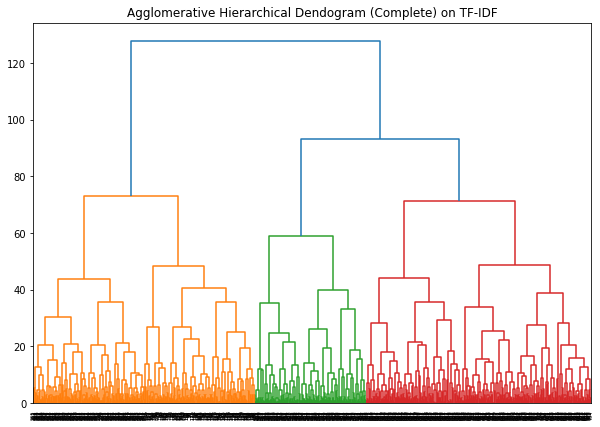

In [ ]:
#AHC Complete on TF-IDF
tfidf_agg_complete, tfidf_agg_complete_pred= agg_hierarchical_cluster(6, tfidf_data,"Agglomerative Hierarchical Dendogram (Complete) on TF-IDF", "complete")

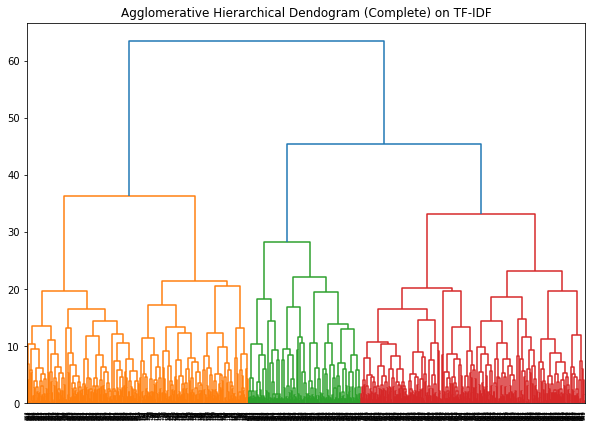

In [ ]:
#AHC Average on TF-IDF
tfidf_agg_avg, tfidf_agg_avg_pred= agg_hierarchical_cluster(6, tfidf_data,"Agglomerative Hierarchical Dendogram (Complete) on TF-IDF", "average")

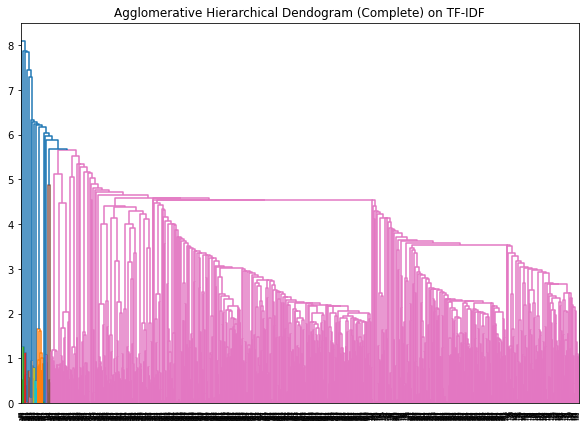

In [ ]:
#AHC Single on TF-IDF
tfidf_agg_single, tfidf_agg_single_pred= agg_hierarchical_cluster(6, tfidf_data,"Agglomerative Hierarchical Dendogram (Complete) on TF-IDF", "single")

Ward results look better of the lot. Hence we'll be using it for further evaluation.

LDA & K-Means

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


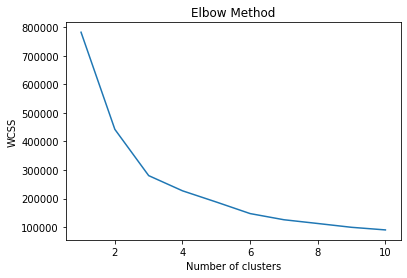

In [ ]:
lda_data = data_with_tsna(pred_new[0])
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(lda_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

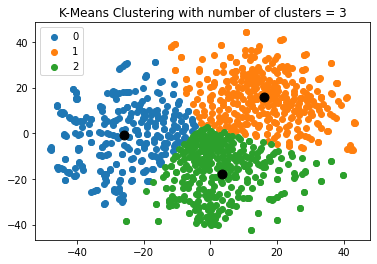

In [ ]:
lda_kmeans, lda_kmeans_pred = kMeans(3, lda_data)

LDA & EM

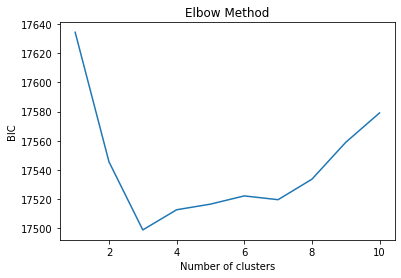

In [ ]:
bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical', n_init=10)
    gmm.fit(lda_data)
    bic.append(gmm.bic(lda_data))
plt.plot(range(1, 11), bic)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.show()

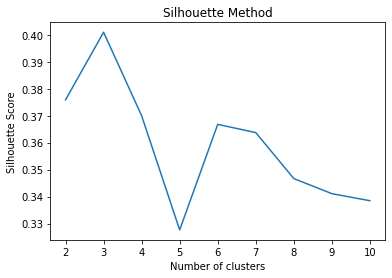

In [ ]:
silhouette_scores = []
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, covariance_type='spherical', n_init=10)
    gmm.fit(lda_data)
    y_pred = gmm.predict(lda_data)
    score = silhouette_score(lda_data, y_pred)
    silhouette_scores.append(score)
    
optimal_clusters = np.argmax(silhouette_scores) + 2

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

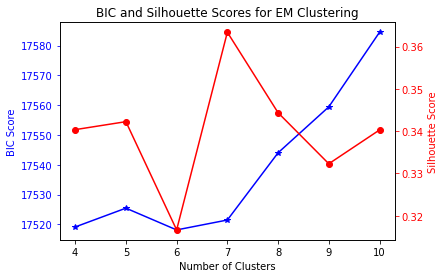

Best number of clusters (combined method): 10
BIC score for best number of clusters: 17584.454139802056
Silhouette score for best number of clusters: 0.3402721


In [ ]:
combine(lda_data)

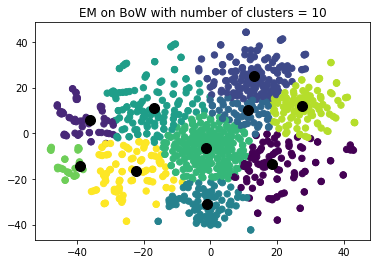

In [ ]:
lda_em, lda_em_pred, lda_em_proba = em(10, lda_data)

LDA & Agglomerative Hierarchical Clustering

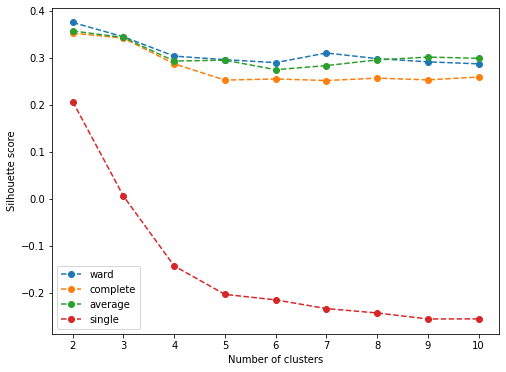

In [ ]:
agglomerative_elbow(lda_data)

Ward = 6, Complete = 5, Average = 3, Single = 4

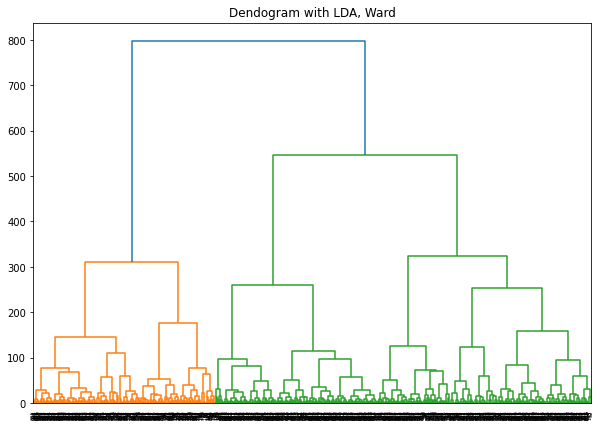

In [ ]:
lda_agg_ward, lda_agg_ward_pred= agg_hierarchical_cluster(6, lda_data, "Dendogram with LDA, Ward", "ward")

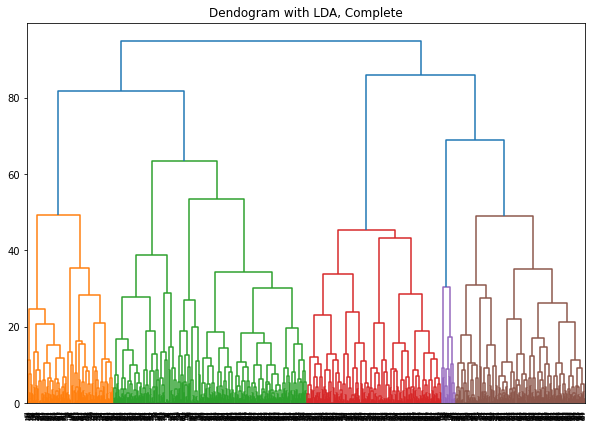

In [ ]:
lda_agg_complete, lda_agg_complete_pred= agg_hierarchical_cluster(5, lda_data, "Dendogram with LDA, Complete", "complete")

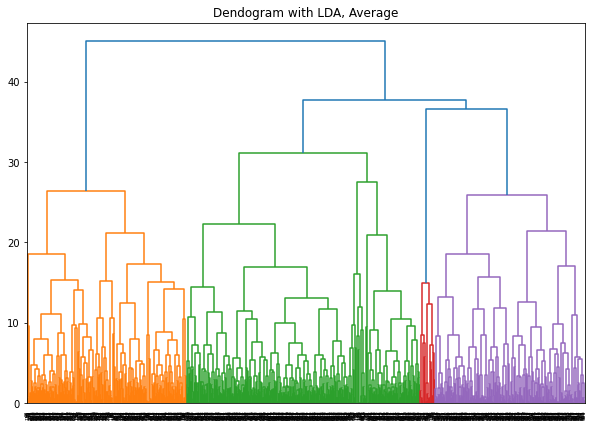

In [ ]:
lda_agg_avg, lda_agg_avg_pred= agg_hierarchical_cluster(3, lda_data, "Dendogram with LDA, Average", "average")

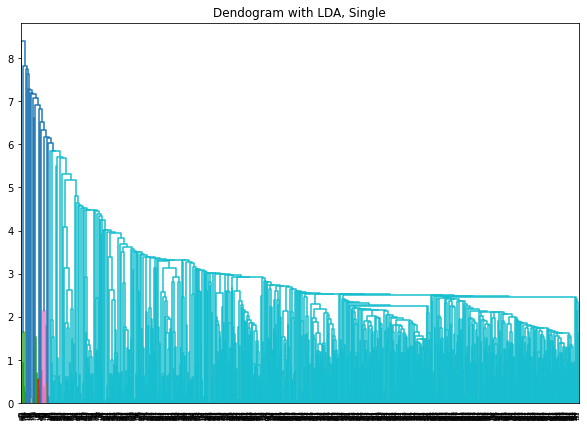

In [ ]:
lda_agg_single, lda_agg_single_pred= agg_hierarchical_cluster(5, lda_data, "Dendogram with LDA, Single", "single")

# Evaluation

# 1. Cohen's Kappa


Cohen's Kappa on K-Means

In [ ]:
print("Kappa Score of K-means With BOW: {:.4f}".format(cohen_kappa_score(result['true_label'],bow_kmeans_pred)))
print("Kappa Score of K-means With TFIDF:  {:.4f}".format(cohen_kappa_score(result['true_label'], tfidf_kmeans_pred)))
print("Kappa Score of K-means With LDA:  {:.4f}".format(cohen_kappa_score(result['true_label'],lda_kmeans_pred)))

Kappa Score of K-means With BOW: 0.0875
Kappa Score of K-means With TFIDF:  -0.0391
Kappa Score of K-means With LDA:  0.0387


Cohen's Kappa on EM

In [ ]:
print("Kappa Score of EM With BOW:  {:.4f}".format(cohen_kappa_score(result['true_label'],bow_em_pred)))
print("Kappa Score of EM With TFIDF:  {:.4f}".format(cohen_kappa_score(result['true_label'], tfidf_em_pred)))
print("Kappa Score of EM With LDA:  {:.4f}".format(cohen_kappa_score(result['true_label'],lda_em_pred)))

Kappa Score of EM With BOW:  0.0175
Kappa Score of EM With TFIDF:  0.1729
Kappa Score of EM With LDA:  -0.0164


Cohen's Kappa on Agglomerative Hierarchical Clustering

In [ ]:
print("Kappa Score of AHC With BOW:  {:.4f}".format(cohen_kappa_score(result['true_label'],bow_agg_ward_pred))) 
print("Kappa Score of AHC With TFIDF:  {:.4f}".format(cohen_kappa_score(result['true_label'], tfidf_agg_ward_pred)))
print("Kappa Score of AHC With LDA:  {:.4f}".format(cohen_kappa_score(result['true_label'],lda_agg_ward_pred)))

Kappa Score of AHC With BOW:  0.2100
Kappa Score of AHC With TFIDF:  0.2190
Kappa Score of AHC With LDA:  0.0438


# 2. Silhouette

Silhouette on K-Means

In [ ]:
#K-Means on Bag-of-Words
s_score_kmeans_bow = silhouette_score(bow_data,bow_kmeans_pred)
print("Silhouette Score of KMeans with BOW: ",s_score_kmeans_bow)

#K-Means on TF-IDF
s_score_kmeans_tfidf = silhouette_score(tfidf_data,tfidf_kmeans_pred)
print("Silhouette Score of KMeans with TFIDF: ",s_score_kmeans_tfidf)

#K-Means on LDA
s_score_kmeans_lda = silhouette_score(lda_data,lda_kmeans_pred)
print("Silhouette Score of KMeans with LDA: ",s_score_kmeans_lda)

Silhouette Score of KMeans with BOW:  0.3521662
Silhouette Score of KMeans with TFIDF:  0.45226282
Silhouette Score of KMeans with LDA:  0.40210745


Silhouette on EM

In [ ]:
#EM on Bag-of-Words
s_score_em_bow = silhouette_score(bow_data,bow_em_pred)
print("Silhouette Score of EM with BOW: ",s_score_em_bow)

#EM on TF-IDF
s_score_em_tfidf = silhouette_score(tfidf_data,tfidf_em_pred)
print("Silhouette Score of EM with TFIDF: ",s_score_em_tfidf)

#EM on LDA
s_score_em_lda = silhouette_score(lda_data,lda_em_pred)
print("Silhouette Score of EM with LDA: ",s_score_em_lda)

Silhouette Score of EM with BOW:  0.35159117
Silhouette Score of EM with TFIDF:  0.3626668
Silhouette Score of EM with LDA:  0.30176944


Silhouette on Agglomerative Hierarchical Clustering

In [ ]:
#Agglomerative Hierarchical Clustering on Bag-of-Words
s_score_ahc_bow = silhouette_score(bow_data,bow_agg_ward_pred) 
print("Silhouette Score of AHC with BOW: ",s_score_ahc_bow)

#Agglomerative Hierarchical Clustering on TF-IDF
s_score_ahc_tfidf = silhouette_score(tfidf_data,tfidf_agg_ward_pred)
print("Silhouette Score of AHC with TFIDF: ",s_score_ahc_tfidf)

#Agglomerative Hierarchical Clustering on LDA
s_score_ahc_lda = silhouette_score(lda_data,lda_agg_ward_pred)
print("Silhouette Score of AHC with LDA: ",s_score_ahc_lda)

Silhouette Score of AHC with BOW:  0.276574
Silhouette Score of AHC with TFIDF:  0.42078635
Silhouette Score of AHC with LDA:  0.29044732



# 3. Coherence
Coherence is a measure of the interpretability and quality of the topic modeling results. Hence, coherence metrics are applicable to probabilistic models such as LDA.

In [ ]:
# Coherence on LDA
# Compute Perplexity: a measure of how good the model is. The lower the better.
# c_v must be positive, u_mass must be -ve for a good model.
print('\nPerplexity score: ', ldamodel_new.log_perplexity(corpus))  

split = result['text'].tolist()
text_split = [i.split() for i in split]

cm_cv = CoherenceModel(model= ldamodel_new, texts= text_split, dictionary=dictionary, coherence='c_v')
cm_umass = CoherenceModel(model= ldamodel_new, texts= text_split, dictionary=dictionary, coherence='u_mass')
coherence_cv = round(cm_cv.get_coherence(), 4)  # get coherence value
coherence_umass = round(cm_umass.get_coherence(), 4)  # get coherence value
print("\nCoherence score With LDA using c_v: {}".format(coherence_cv))
print("\nCoherence score With LDA using u_mass: {}".format(coherence_umass))



Perplexity score:  -64.843167568609

Coherence score With LDA using c_v: 0.4777

Coherence score With LDA using u_mass: -9.9331


#Best Model based on Sihouette and Kappa scores

In [ ]:
import numpy as np

# Define kappa and silhouette scores of 9 models
#Model 1 = K-MEANS & BOW
#Model 2 = K-MEANS & TF-IDF
#Model 3 = K-MEANS & LDA
#Model 1 = EM & BOW
#Model 2 = EM & TF-IDF
#Model 3 = EM & LDA
#Model 1 = AHC & BOW
#Model 2 = AHC & TF-IDF
#Model 3 = AHC & LDA

# Input kappa and silhouette scores of 9 models
kappa_scores = [0.195, -0.213, -0.0662, 0.1663, 0.0747, -0.0883, 0.0088, -0.1895, 0.0954]
silhouette_scores = [0.3372, 0.40692, 0.3684, 0.2863, 0.3707, 0.3349, 0.319, 0.3868, 0.2961]

# Create a dictionary to store the scores of each model
model_scores = {}

# Calculate the average score for each model
for i in range(len(kappa_scores)):
    avg_score = (kappa_scores[i] + silhouette_scores[i]) / 2
    model_scores[f"Model {i+1}"] = {"Kappa": kappa_scores[i], "Silhouette": silhouette_scores[i], "Average": avg_score}

# Print the scores for each model
for model, scores in model_scores.items():
    print(f"{model}: Kappa={scores['Kappa']:.2f}, Silhouette={scores['Silhouette']:.2f}, Average={scores['Average']:.2f}")

# Find the champion model based on the individual scores
best_kappa = max(model_scores, key=lambda x: model_scores[x]['Kappa'])
best_silhouette = max(model_scores, key=lambda x: model_scores[x]['Silhouette'])

print(f"\nChampion based on Kappa score: {best_kappa}")
print(f"Champion based on Silhouette score: {best_silhouette}")

# Find the champion model based on the average score
best_avg = max(model_scores, key=lambda x: model_scores[x]['Average'])
print(f"Champion based on average score: {best_avg}")


Model 1: Kappa=0.20, Silhouette=0.34, Average=0.27
Model 2: Kappa=-0.21, Silhouette=0.41, Average=0.10
Model 3: Kappa=-0.07, Silhouette=0.37, Average=0.15
Model 4: Kappa=0.17, Silhouette=0.29, Average=0.23
Model 5: Kappa=0.07, Silhouette=0.37, Average=0.22
Model 6: Kappa=-0.09, Silhouette=0.33, Average=0.12
Model 7: Kappa=0.01, Silhouette=0.32, Average=0.16
Model 8: Kappa=-0.19, Silhouette=0.39, Average=0.10
Model 9: Kappa=0.10, Silhouette=0.30, Average=0.20

Champion based on Kappa score: Model 1
Champion based on Silhouette score: Model 2
Champion based on average score: Model 1


In [ ]:
model_scores[0]

#Clustering Results vs Ground Truth

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

y_true = result['true_label']

# Compute ARI, NMI, and FMI scores for BOW & K-MEANS
ari = adjusted_rand_score(y_true, bow_kmeans_pred)
nmi = normalized_mutual_info_score(y_true, bow_kmeans_pred)
fmi = fowlkes_mallows_score(y_true, bow_kmeans_pred)

# Output the scores
print("BOW & K-MEANS:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for TF-IDF & K-MEANS
ari = adjusted_rand_score(y_true, tfidf_kmeans_pred)
nmi = normalized_mutual_info_score(y_true, tfidf_kmeans_pred)
fmi = fowlkes_mallows_score(y_true, tfidf_kmeans_pred)

# Output the scores
print("TF-IDF & K-MEANS:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for LDA & K-MEANS
ari = adjusted_rand_score(y_true, lda_kmeans_pred)
nmi = normalized_mutual_info_score(y_true, lda_kmeans_pred)
fmi = fowlkes_mallows_score(y_true, lda_kmeans_pred)

# Output the scores
print("LDA & K-MEANS:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for BOW & EM
ari = adjusted_rand_score(y_true, bow_em_pred)
nmi = normalized_mutual_info_score(y_true, bow_em_pred)
fmi = fowlkes_mallows_score(y_true, bow_em_pred)

# Output the scores
print("BOW & EM:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for TF-IDF & EM
ari = adjusted_rand_score(y_true, tfidf_em_pred)
nmi = normalized_mutual_info_score(y_true, tfidf_em_pred)
fmi = fowlkes_mallows_score(y_true, tfidf_em_pred)

# Output the scores
print("TF-IDF & EM:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for LDA & EM
ari = adjusted_rand_score(y_true, lda_em_pred)
nmi = normalized_mutual_info_score(y_true, lda_em_pred)
fmi = fowlkes_mallows_score(y_true, lda_em_pred)

# Output the scores
print("LDA & EM:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for BOW & AHC
ari = adjusted_rand_score(y_true, bow_agg_ward_pred)
nmi = normalized_mutual_info_score(y_true, bow_agg_ward_pred)
fmi = fowlkes_mallows_score(y_true, bow_agg_ward_pred)

# Output the scores
print("BOW & AHC:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for TF-IDF & AHC
ari = adjusted_rand_score(y_true, tfidf_agg_ward_pred)
nmi = normalized_mutual_info_score(y_true, tfidf_agg_ward_pred)
fmi = fowlkes_mallows_score(y_true, tfidf_agg_ward_pred)

# Output the scores
print("TF-IDF & AHC:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

# Compute ARI, NMI, and FMI scores for LDA & AHC
ari = adjusted_rand_score(y_true, lda_agg_ward_pred)
nmi = normalized_mutual_info_score(y_true, lda_agg_ward_pred)
fmi = fowlkes_mallows_score(y_true, lda_agg_ward_pred)

# Output the scores
print("LDA & AHC:")
print(f"ARI score: {ari:.2f}")
print(f"NMI score: {nmi:.2f}")
print(f"FMI score: {fmi:.2f}")
print("\n")

BOW & K-MEANS:
ARI score: 0.33
NMI score: 0.40
FMI score: 0.47


TF-IDF & K-MEANS:
ARI score: 0.81
NMI score: 0.84
FMI score: 0.85


LDA & K-MEANS:
ARI score: 0.29
NMI score: 0.32
FMI score: 0.48


BOW & EM:
ARI score: 0.33
NMI score: 0.42
FMI score: 0.51


TF-IDF & EM:
ARI score: 0.58
NMI score: 0.71
FMI score: 0.67


LDA & EM:
ARI score: 0.20
NMI score: 0.30
FMI score: 0.33


BOW & AHC:
ARI score: 0.25
NMI score: 0.35
FMI score: 0.45


TF-IDF & AHC:
ARI score: 0.76
NMI score: 0.79
FMI score: 0.81


LDA & AHC:
ARI score: 0.21
NMI score: 0.26
FMI score: 0.36




#Error Analysis

For Clusters = 3 The Average Silhouette Score is : 0.40210745 



<ipython-input-56-9848b594e694>:65: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,


For Clusters = 4 The Average Silhouette Score is : 0.363839 



<ipython-input-56-9848b594e694>:65: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,


For Clusters = 5 The Average Silhouette Score is : 0.3438913 



<ipython-input-56-9848b594e694>:65: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,


For Clusters = 6 The Average Silhouette Score is : 0.3669989 



<ipython-input-56-9848b594e694>:65: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,


For Clusters = 7 The Average Silhouette Score is : 0.36224973 



<ipython-input-56-9848b594e694>:65: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,


For Clusters = 8 The Average Silhouette Score is : 0.3534402 



<ipython-input-56-9848b594e694>:65: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,


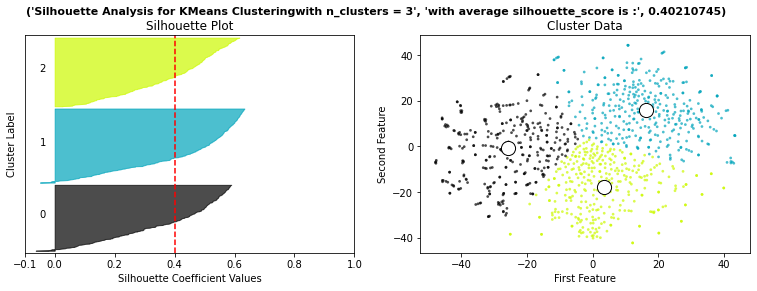

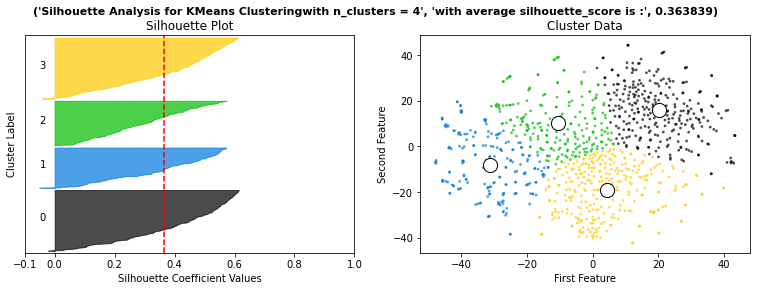

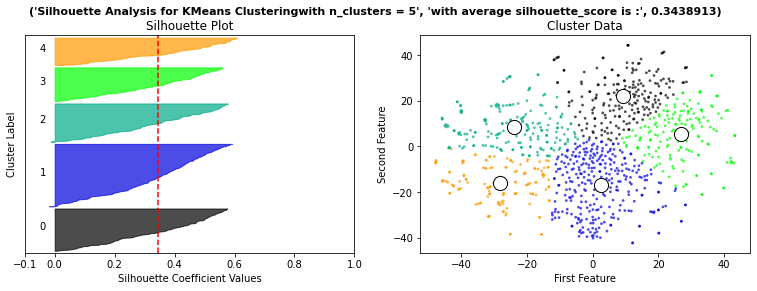

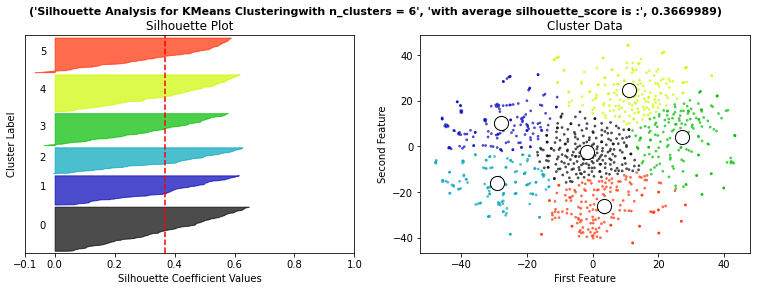

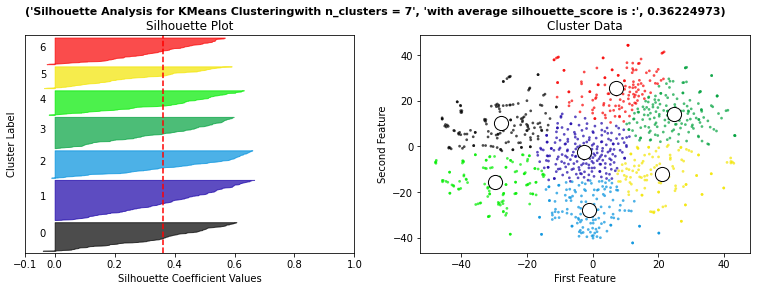

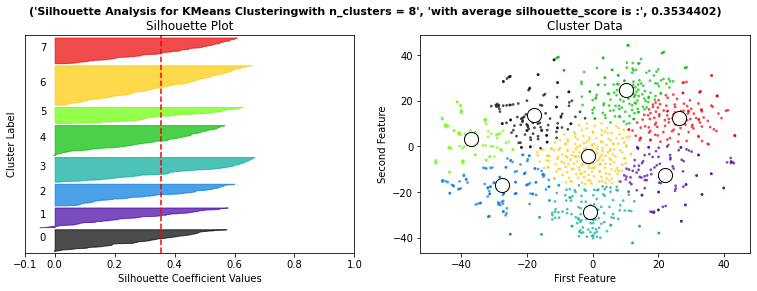

In [ ]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
range_n_clusters = [ 3, 4, 5, 6,7,8]
sil_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(13, 4)
    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(lda_data) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(lda_data)


    silhouette_avg = silhouette_score(lda_data, cluster_labels)
    sil_scores.append(silhouette_avg)
    print("For Clusters =", n_clusters,
          "The Average Silhouette Score is :", silhouette_avg ,"\n")


    sample_silhouette_values = silhouette_samples(lda_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(lda_data[:, 0], lda_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=''.format(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Cluster Data")
    ax2.set_xlabel("First Feature")
    ax2.set_ylabel("Second Feature")

    plt.suptitle(("Silhouette Analysis for KMeans Clustering"
                  "with n_clusters = %d" % n_clusters ,"with average silhouette_score is :", silhouette_avg ),
                 fontsize=11, fontweight='bold')

plt.show()

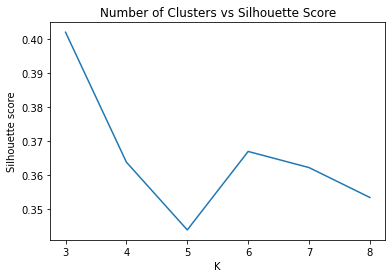

In [ ]:
plt.plot(range_n_clusters , sil_scores )
plt.title("Number of Clusters vs Silhouette Score")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

In [ ]:
def analysis_data (features_eng_results , data):
  analysis_df = data[['text', 'label' , "true_label" ]]
  analysis_df['cluster_output'] = pd.DataFrame(features_eng_results.astype(str))
  return analysis_df

In [ ]:
from collections import Counter

def most_frequent_words(num_words ,df_name , label_column , docu_column):
  genres = []
  for label in df_name[label_column].unique():
    genre = df_name[df_name[label_column]==label][docu_column]
    genres.append(genre)

  clusters_label= []
  for cls in range(len(genres)):
    lab = []
    for doc in genres[cls]:
      text = ""
      text += doc
      text += " "
      lab.append(text)
    clusters_label.append(lab)

  clusters_content = []
  for i in range(len(clusters_label)):
    whole_texts = ""
    for j in range(len(clusters_label[i])):
      whole_texts += clusters_label[i][j]
      whole_texts += " "
    clusters_content.append(whole_texts)

  most_frequent_words = []
  most_frequent_words_weights = []

  for ele in range(len(clusters_content)):
    word_list =[]
    weights_list = []
    string = clusters_content[ele]
    split_it = string.split()
    Count = Counter(split_it)
    most_occur = Count.most_common(num_words)
    for tup in range(len(most_occur)): 
      fw =  most_occur[tup][0]
      weights = most_occur[tup][1]
      word_list.append(fw)
      weights_list.append(weights)

    most_frequent_words.append(word_list)
    most_frequent_words_weights.append(weights_list)

  return most_frequent_words , most_frequent_words_weights

In [ ]:
# Create dictionary of matches 
def matches_dict(labels_mf , clusters_label_mf):
  lab_cls_match = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mf)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      scores_i.append(matches)
    lab_cls_match[i] = scores_i 
  return lab_cls_match
     

# Create dictionary of matches_weights
def weights_dict(labels_mf , clusters_label_mf ,clusters_mfw ):
  lab_cls_match_weights = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mfw)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      weight = sum(clusters_mfw[j][0:matches])
      scores_i.append(weight)
    lab_cls_match_weights[i] = scores_i 
  return lab_cls_match_weights
     

#show list most frequent words and there weights
def most_frequent_words_weights(lbl_list , wgt_list):
  list_most_frequent_words_weights = []
  for i  in range(len(lbl_list)):
    lis = []
    for f, b in zip(lbl_list[i], wgt_list[i]):
      element = [f ,b]
      ele= tuple(element)
      lis.append(ele)
    list_most_frequent_words_weights.append(lis)   
  return list_most_frequent_words_weights
     

analysis_df = analysis_data(lda_kmeans_pred , result)
analysis_df
     

labels_mf , labels_mfw  = most_frequent_words (25, 
                                               analysis_df,
                                               "true_label",
                                               "text")

clusters_mf,clusters_mfw = most_frequent_words( 25,
                                               analysis_df,
                                               "cluster_output",
                                               "text")

lab_cls_match = matches_dict(labels_mf , clusters_mf)
lab_cls_match
     

lab_cls_weights = weights_dict(labels_mf ,
                               clusters_mf ,
                               clusters_mfw)
lab_cls_weights
     

frequent_elements_labels = most_frequent_words_weights(labels_mf,labels_mfw)
print("\n Frequent Words With Occurences Through the Actual Class\n")
print("Most Frequent Words in Label 0  \n ", frequent_elements_labels[0] ,"\n")
print("Most Frequent Words in Label 1  \n ", frequent_elements_labels[1] ,"\n")
print("Most Frequent Words in Label 2  \n ", frequent_elements_labels[2] ,"\n")
print("Most Frequent Words in Label 3  \n ", frequent_elements_labels[3] ,"\n")
print("Most Frequent Words in Label 4  \n ", frequent_elements_labels[4] ,"\n")
     

frequent_elements_weights = most_frequent_words_weights(clusters_mf,clusters_mfw)
print("\n Frequent Words With Occurences Through the Actual Cluster (output) \n")
print("Most Frequent Words in Cluster 0  \n ", frequent_elements_weights[0] ,"\n")
print("Most Frequent Words in Cluster 1  \n ", frequent_elements_weights[1] ,"\n")
print("Most Frequent Words in Cluster 2  \n ", frequent_elements_weights[2] ,"\n")
#print("Most Frequent Words in Cluster 3  \n ", frequent_elements_weights[3] ,"\n")
#print("Most Frequent Words in Cluster 4  \n ", frequent_elements_weights[4] ,"\n")


 Frequent Words With Occurences Through the Actual Class

Most Frequent Words in Label 0  
  [('say', 173), ('like', 134), ('brown', 108), ('look', 99), ('father', 92), ('man', 90), ('one', 86), ('come', 64), ('make', 62), ('go', 59), ('would', 57), ('even', 56), ('old', 56), ('could', 55), ('seem', 53), ('little', 51), ('well', 50), ('thing', 50), ('think', 50), ('something', 46), ('still', 46), ('priest', 46), ('know', 45), ('black', 43), ('get', 41)] 

Most Frequent Words in Label 1  
  [('mr', 171), ('anne', 159), ('could', 137), ('elliot', 100), ('captain', 94), ('would', 90), ('must', 85), ('go', 80), ('say', 77), ('much', 77), ('see', 75), ('make', 67), ('well', 67), ('good', 66), ('wentworth', 64), ('might', 64), ('lady', 62), ('one', 61), ('little', 59), ('know', 56), ('time', 56), ('come', 51), ('never', 51), ('give', 50), ('think', 49)] 

Most Frequent Words in Label 2  
  [('thee', 170), ('little', 168), ('weep', 137), ('love', 135), ('like', 126), ('thou', 125), ('child',

<ipython-input-58-9515003afcdd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['cluster_output'] = pd.DataFrame(features_eng_results.astype(str))
